In [1]:
import cv2
import numpy as np
import random
import os, sys, glob, pickle
from xml.dom import minidom
import matplotlib.path as mplPath
import numpy as np
#import openslide
import time
import pdb
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
# resnet50 = models.resnet50(pretrained=True).to(device)

In [4]:
# MODEL_PATH = '_ckpt_epoch_9.ckpt'
# RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
# NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


# def load_model_weights(model, weights):

#     model_dict = model.state_dict()
#     weights = {k: v for k, v in weights.items() if k in model_dict}
#     if weights == {}:
#         print('No weight could be loaded..')
#     model_dict.update(weights)
#     model.load_state_dict(model_dict)

#     return model


# model = models.__dict__['resnet18'](pretrained=False)

# state = torch.load(MODEL_PATH, map_location=device)

# state_dict = state['state_dict']
# for key in list(state_dict.keys()):
#     state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

# model = load_model_weights(model, state_dict)

# if RETURN_PREACTIVATION:
#     model.fc = torch.nn.Sequential()
# else:
#     model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

# model = model.cuda()

In [5]:
MODEL_PATH = 'tenpercent_resnet18.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model


model = models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location=device)

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)

if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.cuda()

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self, model):
        super(SiameseNetwork, self).__init__()
        self.model = model
    
    def forward_once(self, x):
        out = self.model(x)
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

In [7]:
class SiamDataset(Dataset):
    def __init__(self, img_file_list, mode='load', affine_param=5, jitter_param=0.4, detailed=False):
        self.img_file_list = img_file_list
        self.detailed = detailed
        self.randomCrop = torchvision.transforms.RandomCrop(224)
        
        self.toTensor = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
            ])
        
        self.mode = mode
        if mode=='create':
            self.single_transform = torchvision.transforms.Compose([
                torchvision.transforms.RandomCrop(224),
                torchvision.transforms.ToTensor()
            ])
            self.augment = torchvision.transforms.Compose([
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomAffine(affine_param),
                torchvision.transforms.ColorJitter(
                    brightness=jitter_param,
                    contrast=jitter_param,
                    saturation=jitter_param),
                torchvision.transforms.ToTensor()
            ])

            self.wsi_list = []
            self.wsi_weight = []
            for img_file in img_file_list:
                wsi = Image.open(img_file).convert('RGB')
                self.wsi_list.append(wsi)
                h,w = wsi.size
                self.wsi_weight.append(h*w)
            
            
            
        
    def sample(self):
        wsi = random.choices(self.wsi_list, weights=self.wsi_weight)[0]

        img = self.single_transform(wsi)
        
        return img
    
    def sample_double(self):
        img1 = self.sample()
        img2 = self.augment(img1)
        
        return img1, img2
    
    def get_augmented(self, img):
        op = self.augment(img)
        
        return op
        

    
    
    def sample_detailed(self):
        wsi = random.choices(self.wsi_list, weights=self.wsi_weight)[0]
        wsi_idx = self.wsi_list.index(wsi)
        
        i,j,h,w = self.randomCrop.get_params(wsi, self.randomCrop.size)
        
        return wsi_idx, i,j, self.toTensor(F.crop(wsi, i,j,h,w))
               
        
    def __getitem__(self, index):
        if self.mode=='create':
            img1 = self.sample()

            augment = np.random.binomial(1,0.5)

            img2 = self.augment(img1) if augment else self.sample()
        else:
            pkl = open(self.img_file_list[index], "rb")
            img1, img2, augment = pickle.load(pkl)
            pkl.close()
        
        return [img1, img2, augment]
        
        
        
    def __len__(self):
        if self.mode=='create':
            acc = 0
            for wsi in self.wsi_list:
                h,w = wsi.size
                acc += 1.*h*w/(224*224)
            return int(acc)
        
        return len(self.img_file_list)

In [8]:
def create_dataset():
    img_file_list = glob.glob('/home/karman/DDP/TCGA_expt/TCGA_dataset/*/*.png') 
    # address in himalaya ("/home/Drive3/Karman/TCGA_dataset/TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D2-F4C2EBC6EB9F/*.png")
    dataset = SiamDataset(img_file_list, mode='create')

    out_file_path = '/home/karman/DDP/BrC_GraphMIL/data/tcga_'
    # address in himalaya "data/tcga_"
    if not os.path.exists(out_file_path):
        os.makedirs(out_file_path)

    torch.manual_seed(77077)
    random.seed(71017)

    idx=0
    for data in dataset:
        pickle_out = open(out_file_path+str(idx),"wb")
        pickle.dump(data, pickle_out)
        pickle_out.close()
        idx += 1
        if idx>=len(dataset):
            break

#create_dataset()

In [9]:
class ContrastiveLoss(nn.Module):
    # label == 1 means same sample, label == 0 means different samples
    def __init__(self, margin=1., do_average=True):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-6
        self.relu = nn.ReLU()
        self.do_average = do_average
    
    def forward(self, out1, out2, labels):
        dist = (out1 - out2).pow(2).sum(1)
        loss = 0.5*(labels*dist + 
                   (1 + -1.*labels)*self.relu(self.margin - (dist+self.eps).sqrt()).pow(2))
        return loss.mean() if self.do_average else loss.sum()

In [10]:
def train(args, model, device, loss_fn, train_loader, optimizer, num_epochs):
    
    
    for epoch in range(num_epochs): 
        epoch_loss = 0.
        for batch_idx, data in enumerate(train_loader):
            x1 = data[0].to(device)
            x2 = data[1].to(device)
            label = data[2].to(device)
            

            optimizer.zero_grad()

            model.train()

            out1, out2 = model(x1, x2)

            loss = loss_fn(out1, out2, label) # calculates the loss
            curr_loss = loss.item()
            loss.backward()
            optimizer.step()
            epoch_loss += curr_loss
            
            del x1
            del x2
            del label
            
            if batch_idx % args['log_interval'] == 0 :
                print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.4f}'.format(
                    epoch, 100. * (batch_idx+1) / len(train_loader), curr_loss))
            if batch_idx+1 == len(train_loader):
                print('\nEpoch: {} Total Loss: {:.4f}\n'.format(epoch, epoch_loss))

In [11]:
args = {}
args['batch_size'] = 150
args['epochs'] = 3
args['seed']=990077
args['lr']=0.01
args['train_ratio']=0.8
args['log_interval']=8

torch.manual_seed(args['seed'])

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [12]:
siamNetwork = SiameseNetwork(model)

data_file_list = sorted(glob.glob("data/*"))
dataset = SiamDataset(data_file_list)

train_loader = DataLoader(dataset=dataset, batch_size=args['batch_size'], shuffle = True, **kwargs)

loss_fn = ContrastiveLoss(do_average=False)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

In [13]:
train(args, siamNetwork, device, loss_fn, train_loader, optimizer, args['epochs'])

Train Epoch: 0 [(1%)]	Loss: 795.6233
Train Epoch: 0 [(5%)]	Loss: 12.6194
Train Epoch: 0 [(9%)]	Loss: 9.1906
Train Epoch: 0 [(13%)]	Loss: 9.2148
Train Epoch: 0 [(17%)]	Loss: 6.5164
Train Epoch: 0 [(21%)]	Loss: 5.5981
Train Epoch: 0 [(25%)]	Loss: 5.3614
Train Epoch: 0 [(29%)]	Loss: 5.5238
Train Epoch: 0 [(33%)]	Loss: 3.8315
Train Epoch: 0 [(37%)]	Loss: 4.5859
Train Epoch: 0 [(41%)]	Loss: 3.8896
Train Epoch: 0 [(45%)]	Loss: 5.4484
Train Epoch: 0 [(49%)]	Loss: 3.2006
Train Epoch: 0 [(54%)]	Loss: 2.2850
Train Epoch: 0 [(58%)]	Loss: 2.1377
Train Epoch: 0 [(62%)]	Loss: 2.9480
Train Epoch: 0 [(66%)]	Loss: 2.4829
Train Epoch: 0 [(70%)]	Loss: 3.4491
Train Epoch: 0 [(74%)]	Loss: 4.4375
Train Epoch: 0 [(78%)]	Loss: 2.0389
Train Epoch: 0 [(82%)]	Loss: 2.5307
Train Epoch: 0 [(86%)]	Loss: 2.2763
Train Epoch: 0 [(90%)]	Loss: 1.8654
Train Epoch: 0 [(94%)]	Loss: 3.3121
Train Epoch: 0 [(98%)]	Loss: 1.6532

Epoch: 0 Total Loss: 1928.0465

Train Epoch: 1 [(1%)]	Loss: 2.5094
Train Epoch: 1 [(5%)]	Loss: 2.91

In [14]:
torch.save({
    'epoch': args['epochs'],
    'model_state_dict': siamNetwork.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, 'checkpoints/siamese_3epoch_1wsi_lossSum.pth.tar')

In [13]:
checkpoint = torch.load('checkpoints/siamese_3epoch_10percentwsi_lossSum.pth.tar')
# args['epochs'] = checkpoint['epoch']
siamNetwork.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [14]:
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from time import time
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
%matplotlib inline

# Next line to silence pyflakes. This import is needed.
Axes3D



mpl_toolkits.mplot3d.axes3d.Axes3D

In [15]:
# get 2000 images embedded for tsne
img_file_list = glob.glob('/home/karman/DDP/TCGA_expt/TCGA_dataset/*/*.png')
# address in himalaya ("/home/Drive3/Karman/TCGA_dataset/TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D2-F4C2EBC6EB9F/*.png")
dataset = SiamDataset(img_file_list, mode='create', detailed=True)

In [16]:
from kmeans_pytorch import kmeans

torch.manual_seed(90515)
random.seed(88054)


count = 0
num_samples = 2000
wsi_idx_list = np.zeros(num_samples, dtype=int)
pt_list = np.zeros([num_samples,2], dtype=int)
sample_size = 512

x_cluster = torch.Tensor(num_samples, sample_size)
# print(x_cluster)
# torch.cat(data_arr, dim=0, out=x_cluster)
# #torch.cat(data_arr, dim=0)
# print(x_cluster.shape)


siamNetwork.eval()

with torch.no_grad():
    for idx in range(1000):
        wsi_idx, i,j, img = dataset.sample_detailed()
        wsi_idx_list[idx] = wsi_idx
        pt_list[idx,:] = i,j

        x_cluster[idx,:] = siamNetwork.forward_once(img.unsqueeze(dim=0).to(device))

        del img
#     for idx in range(0, 2000, 2):
#         img1, img2 = dataset.sample_double()
#         x_cluster[idx,:] = siamNetwork.forward_once(img1.unsqueeze(dim=0).to(device))
#         x_cluster[idx+1,:] = siamNetwork.forward_once(img2.unsqueeze(dim=0).to(device))
    img = dataset.sample()
    for idx in range(1000, 2000):
        img1 = dataset.get_augmented(img)
        
        x_cluster[idx,:] = siamNetwork.forward_once(img1.unsqueeze(dim=0).to(device))
        
        del img1
    del img
        
        
            
    
    

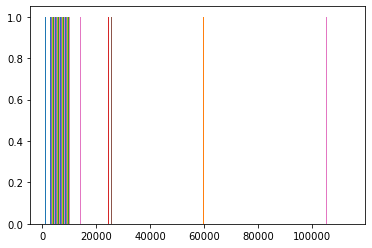

In [18]:
plt.hist(x_cluster.histc())
plt.show() 

In [17]:
num_clusters = 5

t0 = time()
cluster_ids_x, cluster_centers = kmeans(
    X=x_cluster, num_clusters=num_clusters, distance='euclidean', device=device
)
t1 = time()
print("%s: %.2g sec" % ("time", t1 - t0))


[running kmeans]: 36it [00:00, 178.89it/s, center_shift=0.000674, iteration=37, tol=0.000100]

running k-means on cuda..


[running kmeans]: 42it [00:00, 184.69it/s, center_shift=0.000000, iteration=43, tol=0.000100]

time: 0.23 sec


In [19]:
print(type(x_cluster))
print(x_cluster.shape)

X = x_cluster.numpy()

print(type(X))
print(X.shape)

<class 'torch.Tensor'>
torch.Size([2000, 512])
<class 'numpy.ndarray'>
(2000, 512)


In [20]:
# x = data_arr
# x = np.asarray([i.cpu().numpy() for i in x])
# X = x.squeeze()

X = x_cluster.numpy()

# n_components = X.shape[-1]
n_components = 2

method = manifold.TSNE(n_components=n_components, init='pca', random_state=79)


time: 5 sec


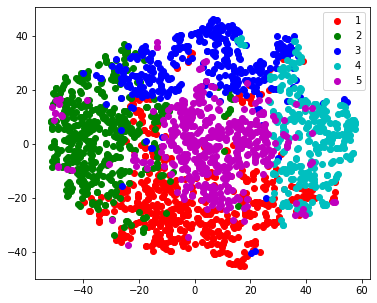

In [21]:
# # Create figure
# fig = plt.figure()

# # Add 3d scatter plot
# ax = fig.add_subplot(251, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

t0 = time()
Y = method.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % ("time", t1 - t0))
# # ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
# ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
# ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# ax.axis('tight')

# plt.show()




plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple'
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_clusters):
    plt.scatter(Y[cluster_ids_x==i, 0], Y[cluster_ids_x==i, 1], c=colors[i], label=labels[i])
plt.legend()
plt.show()

In [22]:
counts = []
for i in range(num_clusters):
    counts.append(len(cluster_ids_x[cluster_ids_x == i]))
counts

[497, 452, 325, 299, 427]

In [23]:
cluster_ids_x ==1

tensor([False, False, False,  ..., False, False, False])

In [24]:
wsi_idx_list = np.array(wsi_idx_list)

In [25]:
wsi_idx_list == 1

array([ True, False, False, ..., False, False, False])

In [26]:
print(len(cluster_ids_x), len(wsi_idx_list) )

2000 2000


In [27]:
print(len(pt_list[wsi_idx_list == 1]), len(cluster_ids_x[wsi_idx_list==1]))

101 101


In [28]:
pt_list

array([[ 6928,  1253],
       [ 8950, 10335],
       [ 6991,    38],
       ...,
       [   39,  2891],
       [ 3901,  6860],
       [11522, 11164]])

In [19]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os

def display_images(
    images: [PilImage], 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

In [30]:
#colors = 'r', 'g', 'b', 'c', 'm'#, 'y', 'k', 'w', 'orange', 'purple'
colors = [(255,0,0), (0,255,0), (0,0,255), (0,255,255), (255,0,255), (255,255,0), (0,0,0), (255,165,0), (230,230,250)]
col_size = 100
idx = 0
images = []
counts = []
for img_file in range(len(img_file_list)):
    
    pt_img = pt_list[wsi_idx_list == idx]
    cluster_img = cluster_ids_x[wsi_idx_list==idx]
    
    assert len(pt_img) == len(cluster_img)
    
    idx += 1
    
    wsi = Image.open(img_file_list[img_file]).convert('RGB')
    w,h = wsi.size
    dim = min(w,h)
    wsi = wsi.crop((0,0,dim,dim))
    
    for idx2 in range(len(pt_img)):
        coordinates = (pt_img[idx2,0]-col_size, pt_img[idx2,1]-col_size, pt_img[idx2,0]+col_size, pt_img[idx2,1]+col_size)
        wsi.paste(colors[cluster_img[idx2]], coordinates)
    
    images.append(wsi)

#display_images(images, columns=2)
    
    
    
        
    
    
    
    

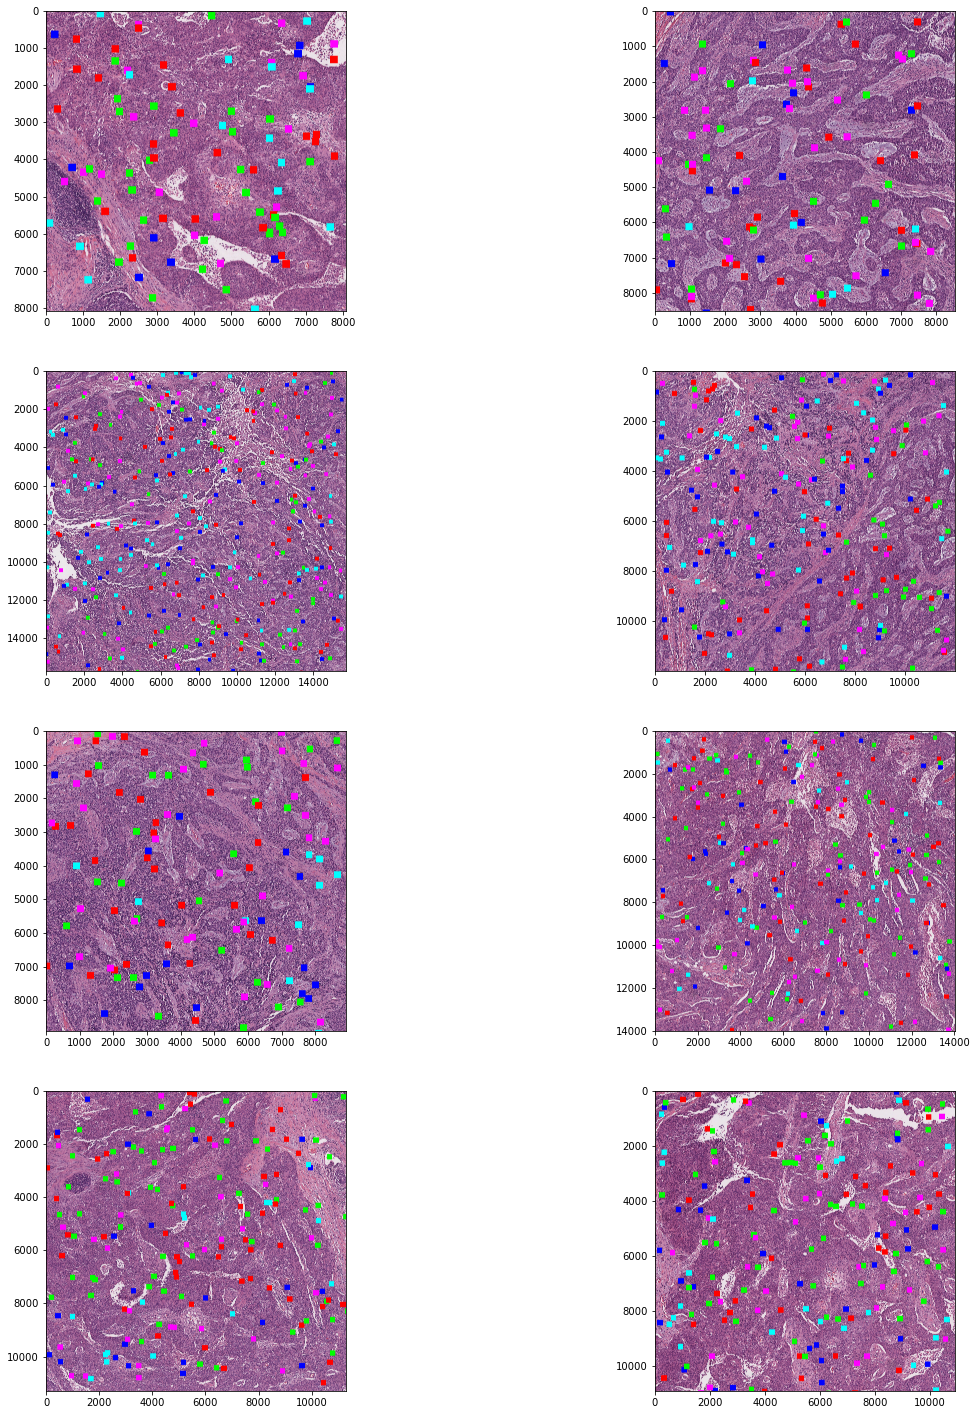

In [31]:
display_images(images, columns=2)

In [32]:
images[0].size

(8090, 8090)

In [33]:
print(X.shape)
print(type(X))
# print(Y.shape)
print(X[0,0:10])
# print(Y[0])
print(cluster_ids_x.shape)
print(cluster_ids_x)

(2000, 512)
<class 'numpy.ndarray'>
[0.20092449 0.11247765 0.26893786 0.1418552  0.11424025 0.11414617
 0.23217493 0.19440638 0.28080735 0.12626432]
torch.Size([2000])
tensor([4, 2, 4,  ..., 0, 3, 4])


In [34]:
xx = torch.from_numpy(X)
print(xx.shape)
xx = torch.cat((cluster_ids_x.view(2000,1), xx),1)
print(xx.shape)
print(xx[:,0])

xx = xx[xx[:,0].sort()[1]]

print(len((xx[:,0]==0).nonzero()))
print(xx[333:345,0])

torch.Size([2000, 512])
torch.Size([2000, 513])
tensor([4., 2., 4.,  ..., 0., 3., 4.])
497
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


/home/karman/anaconda3/envs/geo37/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  if __name__ == '__main__':


In [35]:
import torch_geometric.transforms as T
import torch_geometric.nn as geo_nn
# from torch.utils.data import Dataset
from torch_geometric.data import Data, Dataset, DataLoader

In [36]:
xx = torch.from_numpy(X)
print(xx.shape)
yy = xx.chunk(7)
len(yy)

torch.Size([2000, 512])


7

In [19]:
aa = torch.arange(15).reshape(3,5).float()
print(aa)
dist = torch.cdist(aa, aa, p=2)
print(dist)
print(sum((aa[0]-aa[2])**2)**0.5)

i, j = np.where((dist<15))
print(i,j)
i, j = np.where((dist<15)!=0)
print(i,j)

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]])
tensor([[ 0.0000, 11.1803, 22.3607],
        [11.1803,  0.0000, 11.1803],
        [22.3607, 11.1803,  0.0000]])
tensor(22.3607)
[0 0 1 1 1 2 2] [0 1 0 1 2 1 2]
[0 0 1 1 1 2 2] [0 1 0 1 2 1 2]


In [20]:
num_graphs = 7 # from reference
dist_thresh = 0.72 # for about 15 edges per node

# def makevertices(X, num_graphs):
    # X is tensor
vertices = torch.from_numpy(X).chunk(num_graphs)    
# return graphs
# def makeadjmatrix(graphs):

edges = []
ss1 = 0
count = 0
for vertex in vertices:
    dist = torch.cdist(vertex, vertex, 2)
    i, j = np.where((dist<dist_thresh))
    edge = np.array([i,j])
    edges.append(edge)
    ss1 += sum(sum(dist<dist_thresh))
    count += 1

# graphs = []
# for idx in range(num_graphs):
#     # save graphs
#     save_path_curr
#     data_curr = [[], [], []]
#     data_curr[0] = vertices[idx]
#     data_curr[1] = edges[idx]
#     data_curr[2] = l
#     data_curr = np.asarray(data_curr, dtype = object)
#     if not os.path.exists(save_path_curr.rsplit('/',1)[0]):
#                     os.makedirs(save_path_curr.rsplit('/',1)[0])
#                 with open(save_path_curr,"wb") as file_pickle:
#                     pickle.dump(data_curr, file_pickle)

#                 print(file,count, A.shape,V.shape)
#     graphs.append(Data(x=vertices[idx], edge_index=edges[idx], y=l))
print(1.*ss1/count)


NameError: name 'X' is not defined

In [57]:
sum(sum(dist<0.7))

tensor(3750)

In [17]:
dist = torch.cdist(x_cluster, x_cluster, 2)

In [18]:
dist = dist.flatten()
dist.shape

torch.Size([4000000])

In [19]:
dist.max()

tensor(2.4968)

In [20]:
hh = dist.histc(min = 0, max = 2.7)

In [21]:
hh

tensor([1.0273e+04, 6.6626e+04, 1.7358e+05, 1.9238e+05, 1.7255e+05, 1.4232e+05,
        1.0208e+05, 7.0951e+04, 4.6224e+04, 1.9282e+04, 4.1900e+03, 7.0400e+02,
        2.4400e+02, 2.5800e+02, 4.5400e+02, 9.8600e+02, 1.6000e+03, 2.0840e+03,
        3.0660e+03, 3.3320e+03, 4.9000e+03, 9.4460e+03, 1.2714e+04, 1.4286e+04,
        1.2944e+04, 1.7346e+04, 1.9916e+04, 2.9309e+04, 3.8875e+04, 3.9357e+04,
        3.9683e+04, 4.6572e+04, 5.4808e+04, 6.3396e+04, 6.6560e+04, 7.0744e+04,
        6.9732e+04, 7.5477e+04, 7.7223e+04, 7.6926e+04, 7.7995e+04, 8.6961e+04,
        9.0464e+04, 8.7769e+04, 9.2049e+04, 9.6146e+04, 8.6032e+04, 9.0767e+04,
        8.9798e+04, 8.7973e+04, 8.4239e+04, 9.1830e+04, 8.5355e+04, 8.3188e+04,
        8.3548e+04, 8.0152e+04, 7.7022e+04, 8.1176e+04, 6.2472e+04, 5.3966e+04,
        5.3178e+04, 4.9094e+04, 4.2628e+04, 4.5866e+04, 4.1952e+04, 3.2890e+04,
        3.1228e+04, 2.6484e+04, 2.3452e+04, 2.0828e+04, 2.0528e+04, 2.2134e+04,
        1.4530e+04, 1.5196e+04, 9.2840e+

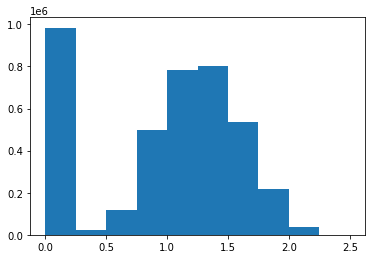

In [22]:
plt.hist(dist.numpy())
plt.show() 

In [35]:
len(dataset)

29310

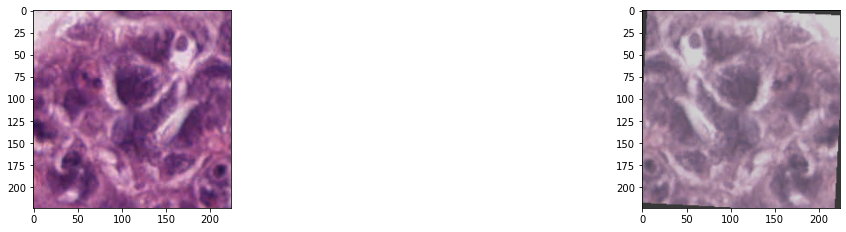

In [39]:
unloader = torchvision.transforms.ToPILImage()
def tensor_to_PIL(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image
img1 = dataset.sample()
img2 = dataset.augment(img1)
img1 = tensor_to_PIL(img1)
img2 = tensor_to_PIL(img2)
display_images([img1, img2], columns=2)

NameError: name 'x_cluster' is not defined